## ДЗ 3:
### Кластеризация весов

In [1]:
import ultralytics
from ultralytics import YOLO

In [2]:
import torch
import time
import torch.quantization
from torch import profiler
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt

In [3]:
torch.seed = 42

In [4]:
def get_model_size(model: torch.nn.Module) -> float:
    """return model size im mb"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    return (param_size + buffer_size) / 1024**2

In [5]:
def profile_model(model, input_example: torch.Tensor = torch.randn(1, 3, 224, 224)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    input_example = input_example.to(device)

    # cold run
    for _ in range(3):
        model(input_example)

    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, with_flops=True) as prof:
        with record_function("model_inference"):
            with torch.inference_mode():
                model(input_example)

    profiling_info = prof.key_averages().table(sort_by="cpu_time_total", row_limit=1)
    return profiling_info

### Исходная модель

In [7]:
yolo = YOLO('yolov8s.pt')
model = yolo.model
model.fuse()
model.eval()
print()

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


In [8]:
print(profile_model(model))
print(f'model size: {get_model_size(model)}')

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Total KFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        -9.74%  -10532.000us       100.00%     108.087ms     108.087ms           0 b     -24.59 Mb             1            --  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 108.087ms

model size: 42.558837890625


STAGE:2023-10-13 14:08:36 80659:2861612 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-10-13 14:08:36 80659:2861612 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-10-13 14:08:36 80659:2861612 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


### Кластеризация весов

In [11]:
import numpy as np
import sklearn
from sklearn.cluster import KMeans

In [14]:
def cluster_weights(weights):
    for name, tensor in weights.items():
        if 'weight' not in name:
            continue  # пропустить тензоры, которые не связаны с весами
        n = np.prod(tensor.shape)  # получить общее количество элементов в тензоре
        arr = tensor.reshape(n,)  # преобразовать тензор в одномерный массив
        kmeans = KMeans(n_init=10, init='random')  # инициализировать K-means со случайной инициализацией
        kmeans.fit(arr.reshape(-1, 1))  # применить K-means
        centroids = kmeans.cluster_centers_.squeeze()  # извлечь центроиды
        dist = np.abs(arr - centroids[0])  # вычислить расстояния до первого центроида
        for i in range(1, len(centroids)):
            dist = np.vstack((dist, np.abs(arr - centroids[i])))  # вычислить расстояния до остальных центроидов
        args_of_cent = dist.argmin(axis=0)  # найти ближайший центроид для каждого элемента
        arr = centroids[args_of_cent]  # заменить каждый элемент его ближайшим центроидом
        weights[name] = torch.Tensor(arr.reshape(tensor.shape))  # обновить тензор весов
    return weights

In [15]:
weights = yolo.model.state_dict()

In [16]:
weights_clustered = cluster_weights(weights)

/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


In [18]:
clustered_yolo = YOLO('yolov8s.pt')
clustered_model = clustered_yolo.model
clustered_model.fuse()
clustered_model.eval()
print()

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


In [19]:
clustered_yolo.model.load_state_dict(weights_clustered)

<All keys matched successfully>

In [26]:
torch.save(weights_clustered, 'weights_clustered.pt')

In [27]:
clustered_yolo.model.load_state_dict(torch.load('weights_clustered.pt'))

<All keys matched successfully>

In [29]:
print(profile_model(model))
print(f'clustered model size: {get_model_size(model)}')

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Total KFLOPs  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        -5.68%   -6011.000us       100.00%     105.825ms     105.825ms           0 b     -24.07 Mb             1            --  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 105.825ms

clustered model size: 42.558837890625


STAGE:2023-10-13 14:23:58 80659:2861612 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-10-13 14:23:59 80659:2861612 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-10-13 14:23:59 80659:2861612 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


WARNING ⚠️ 'source' is missing. Using 'source=/Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/ultralytics/assets'.

image 1/2 /Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 206.1ms
image 2/2 /Users/timur/.pyenv/versions/3.8.0/lib/python3.8/site-packages/ultralytics/assets/zidane.jpg: 384x640 (no detections), 161.6ms
Speed: 2.0ms preprocess, 183.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


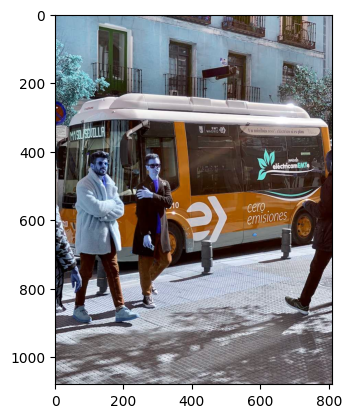

In [29]:
plt.imshow(clustered_yolo.predict(conf=0.01)[0].plot())